# Widening the Space of Similar Values

> A major finding was that the current approaches are considering values that are too similar. This notebook investigates ways to search a wider space.  

In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

In [ ]:
# | hide
from collections import defaultdict
from functools import partial
from operator import itemgetter
from pathlib import Path
from typing import Callable, Dict, List, Optional, Iterable, Protocol, Sequence, Tuple, TypeVar, Type

In [ ]:
#| hide
from fastcore.test import *
import math
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import tempfile
import torch
from torch.nn import functional as F
from tqdm.auto import tqdm

In [ ]:
# | hide

from transformer_experiments.common.substring_generator import all_unique_substrings
from transformer_experiments.common.text_analysis import (
    build_next_token_map,
    SubstringFrequencyAnalysis,
    top_nonzero_tokens
)
from transformer_experiments.common.utils import (
    aggregate_by_string_key,
    DataWrapper,
    topk_across_batches,
)
from transformer_experiments.dataset_split import split_text_dataset
from transformer_experiments.datasets.tinyshakespeare import (
    TinyShakespeareDataSet,
)
from transformer_experiments.environments import get_environment
from transformer_experiments.models.transformer import (
    block_size,
    n_embed,
    n_layer,
    TransformerLanguageModel
)
from transformer_experiments.models.transformer_helpers import (
    unsqueeze_emb,
    EncodingHelpers,
    LogitsWrapper,
    TransformerAccessors
)
from transformer_experiments.trained_models.tinyshakespeare_transformer import (
    create_model_and_tokenizer
)
from transformer_experiments.training_utils import CheckPointer, GetBatchFunction, Trainer
from transformer_experiments.experiments.block_internals import (
    BlockInternalsAccessors,
    BlockInternalsExperiment,
    BatchedBlockInternalsExperiment,
    BlockInternalsAnalysis,
    batch_cosine_sim,
)
from transformer_experiments.experiments.cosine_sims import pre_filter_cosine_sim_results
from transformer_experiments.experiments.final_ffwd import FinalFFWDExperiment
from transformer_experiments.experiments.similar_strings import (
    SimilarStringsData,
    SimilarStringsExperiment,
    SimilarStringsResult
)
from transformer_experiments.experiments.logit_lens import LogitLens

In [ ]:
environment = get_environment()
print(f"environment is {environment.name}")

environment is local_mac


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
ts = TinyShakespeareDataSet(cache_file=environment.code_root / 'nbs/artifacts/input.txt')
m, tokenizer = create_model_and_tokenizer(
    saved_model_filename=environment.code_root / 'nbs/artifacts/shakespeare-20231112.pt',
    dataset=ts,
    device=device,
)
_, val_data = split_text_dataset(ts.text, tokenizer, train_pct=0.9, device=device)
encoding_helpers = EncodingHelpers(tokenizer, device)
accessors = TransformerAccessors(m, device)

In [ ]:
print(f"device is {device}")

device is cpu


In [ ]:
if list((environment.data_root / 'block_internals_results/large_files/slen10/').glob('*')) == []:
    print("Run `make block_internals_slen10_dataset` in the project root to generate the required dataset")

In [ ]:
strings10 = all_unique_substrings(ts.text, 10)

In [ ]:
exp10 = BatchedBlockInternalsExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings10,
    output_dir=environment.data_root / 'block_internals_results/large_files/slen10/',
    batch_size=10000,
)

In [ ]:
torch.manual_seed(1337)
n_samples = 20000
indices = torch.randperm(len(strings10))[:n_samples]
strings20k = [strings10[i.item()] for i in indices]

In [ ]:
# Create a sample of 500 strings
sample_size = 500
strings_sample = strings20k[:sample_size]

In [ ]:
# TODO: put this in a common component
def get_model_outputs(prompts: Sequence[str], encoding_helpers: EncodingHelpers):
    # Compute the model's predictions:
    tokens = encoding_helpers.tokenize_strings(prompts)
    logits, _ = m(tokens)

    logits = LogitsWrapper(logits, encoding_helpers.tokenizer)
    return [topk_tokens[-1] for topk_tokens in logits.topk_tokens(k=10)]


In [ ]:
model_outputs_sample = get_model_outputs(strings_sample, encoding_helpers)

In [ ]:
prompts_exp = BlockInternalsExperiment(encoding_helpers, accessors, strings_sample)

Start by examining what we get when we ask for a much larger top k values. 

In [ ]:
emb_sims, emb_distances = exp10.strings_with_topk_closest_embeddings(
    prompts_exp.embeddings[:5, :, :],
    k=200,
    largest=True,
    distance_function=batch_cosine_sim,
)

In [ ]:
emb_distances[:10, :], emb_distances[-10:, :]

(tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.9062, 0.9470, 0.9045, 0.9493, 0.9544],
         [0.9062, 0.9462, 0.8602, 0.9083, 0.9443],
         [0.9053, 0.9429, 0.8593, 0.9082, 0.9064],
         [0.9037, 0.9429, 0.8586, 0.9055, 0.9057],
         [0.9027, 0.9404, 0.8566, 0.9052, 0.9045],
         [0.9020, 0.9027, 0.8562, 0.9044, 0.8996],
         [0.9017, 0.9009, 0.8548, 0.9035, 0.8982],
         [0.8962, 0.9009, 0.8545, 0.9034, 0.8656],
         [0.8651, 0.9008, 0.8532, 0.9032, 0.8631]]),
 tensor([[0.7591, 0.7566, 0.7604, 0.8064, 0.8047],
         [0.7591, 0.7566, 0.7604, 0.8063, 0.8047],
         [0.7591, 0.7566, 0.7603, 0.8063, 0.8042],
         [0.7590, 0.7564, 0.7602, 0.8063, 0.8041],
         [0.7589, 0.7563, 0.7601, 0.8062, 0.8041],
         [0.7589, 0.7563, 0.7601, 0.8061, 0.8040],
         [0.7588, 0.7557, 0.7601, 0.8061, 0.8039],
         [0.7587, 0.7557, 0.7600, 0.8060, 0.8039],
         [0.7587, 0.7557, 0.7599, 0.8060, 0.8038],
         [0.7587, 0.7557, 0.7

In [ ]:
for j in range(10):
    print(f"{'   '.join([repr(emb_sims[i][j]) for i in range(len(emb_sims))])}")

print()
for j in range(-10, 0):
    print(f"{'   '.join([repr(emb_sims[i][j]) for i in range(len(emb_sims))])}")


'is dreams,'   'by present'   's eyes may'   'eart of ho'   ' man, as I'
'is dream o'   'My present'   's eye, mak'   'eart of mo'   ' men, as I'
'ur dreams,'   'be present'   's eyes in '   'earn of hi'   ' man, as y'
'of dreams,'   'dy present'   'l eyes can'   'ears of ha'   ' man, if I'
'us dreams.'   'my present'   's eyes to '   'park of ho'   'oman, as t'
'he dreams,'   'ry present'   'l eyes gaz'   'eart of ge'   ' men, as i'
'ly dreams,'   'y, present'   'r foes may'   'eard of hi'   ' many as y'
'en dreams,'   'on present'   'r ever may'   'east of yo'   'cian, as I'
'nd dreams,'   't, present'   's eyes do '   'part of hi'   ' son, as t'
'as dream\nS'   'in present'   's eye; tal'   'earn of yo'   ' long as I'

'is presenc'   ' a prisone'   'g over mas'   'efit of se'   ' man: we s'
'is prowess'   'ot prone t'   'l even tak'   'wist of ro'   ' wind as s'
'is be all,'   'is project'   't so I may'   'e is of so'   ' man; all '
'is the mad'   'my person.'   'n thou may'   'gen

In [ ]:
block_idx = 0
proj_sims, proj_distances = exp10.strings_with_topk_closest_proj_outputs(
    block_idx=block_idx,
    t_i=-1,
    queries=prompts_exp.proj_output(block_idx=block_idx)[:5, -1, :],
    k=200,
    largest=True,
    distance_function=batch_cosine_sim,
)

In [ ]:
proj_distances[:10, :], proj_distances[-10:, :]

(tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.9948, 0.9967, 0.9947, 0.9974, 0.9956],
         [0.9942, 0.9967, 0.9945, 0.9960, 0.9933],
         [0.9937, 0.9964, 0.9921, 0.9958, 0.9897],
         [0.9935, 0.9963, 0.9917, 0.9957, 0.9896],
         [0.9928, 0.9962, 0.9910, 0.9956, 0.9871],
         [0.9922, 0.9950, 0.9905, 0.9955, 0.9857],
         [0.9911, 0.9944, 0.9900, 0.9954, 0.9856],
         [0.9897, 0.9942, 0.9895, 0.9950, 0.9850],
         [0.9891, 0.9939, 0.9894, 0.9943, 0.9846]]),
 tensor([[0.9709, 0.9826, 0.9796, 0.9855, 0.9726],
         [0.9709, 0.9825, 0.9795, 0.9855, 0.9726],
         [0.9709, 0.9824, 0.9794, 0.9854, 0.9726],
         [0.9708, 0.9824, 0.9793, 0.9854, 0.9725],
         [0.9708, 0.9824, 0.9793, 0.9854, 0.9725],
         [0.9708, 0.9823, 0.9793, 0.9854, 0.9724],
         [0.9708, 0.9823, 0.9791, 0.9854, 0.9724],
         [0.9708, 0.9823, 0.9791, 0.9853, 0.9724],
         [0.9707, 0.9823, 0.9791, 0.9853, 0.9723],
         [0.9707, 0.9823, 0.9

In [ ]:
for j in range(10):
    print(f"{'   '.join([repr(proj_sims[i][j]) for i in range(len(proj_sims))])}")

print()
for j in range(-10, 0):
    print(f"{'   '.join([repr(proj_sims[i][j]) for i in range(len(proj_sims))])}")


'is dreams,'   'by present'   's eyes may'   'eart of ho'   ' man, as I'
'ly dreams,'   'my present'   'e case may'   'ster of ho'   ' men, as I'
'en dreams,'   'dy present'   ' sense may'   'ffer to ha'   ' and, as I'
'he dreams,'   'ry present'   'ied as may'   'ruth of ho'   ' not, as I'
'ur dreams,'   'be present'   'ay she may'   'otes of ho'   'o me, as I'
'nd dreams,'   'My present'   'r foes may'   'anes of ho'   'nd I, as I'
'ery beams,'   'y; present'   'So she may'   'oint of ho'   'cian, as I'
'of dreams,'   'in present'   ' haste may'   'yers of ho'   'I am, as t'
"n's beams,"   'is present'   'odesty may'   'ains of ho'   '-day, as I'
'hese arms,'   'im present'   'esence may'   'ound of ho'   '\nAnd, as I'

'sires most'   'ast ungent'   "'s some am"   'lf with ho'   ' be, was l'
'teous mass'   'What scene'   'e they mad'   'tell of hi'   'Look, as I'
'm to kiss,'   'lest scent'   ' am to say'   'Thus to ha'   'wick, as o'
'much amiss'   'ondon sent'   ' early mad'   's o

In [ ]:
block_idx = 0
ffwd_sims, ffwd_distances = exp10.strings_with_topk_closest_ffwd_outputs(
    block_idx=block_idx,
    t_i=-1,
    queries=prompts_exp.ffwd_output(block_idx=block_idx)[:5, -1, :],
    k=200,
    largest=True,
    distance_function=batch_cosine_sim,
)

In [ ]:
ffwd_distances[:10, :], ffwd_distances[-10:, :]

(tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
         [0.9998, 0.9999, 0.9997, 0.9998, 0.9999],
         [0.9998, 0.9998, 0.9996, 0.9998, 0.9997],
         [0.9998, 0.9998, 0.9996, 0.9998, 0.9997],
         [0.9998, 0.9998, 0.9995, 0.9998, 0.9997],
         [0.9997, 0.9998, 0.9995, 0.9998, 0.9996],
         [0.9997, 0.9997, 0.9995, 0.9998, 0.9995],
         [0.9997, 0.9997, 0.9995, 0.9998, 0.9995],
         [0.9996, 0.9997, 0.9995, 0.9997, 0.9994],
         [0.9996, 0.9997, 0.9995, 0.9997, 0.9994]]),
 tensor([[0.9988, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9988, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9988, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9988, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9988, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9987, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9987, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9987, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9987, 0.9990, 0.9989, 0.9992, 0.9983],
         [0.9987, 0.9990, 0.9

In [ ]:
for j in range(10):
    print(f"{'   '.join([repr(ffwd_sims[i][j]) for i in range(len(ffwd_sims))])}")

print()
for j in range(-10, 0):
    print(f"{'   '.join([repr(ffwd_sims[i][j]) for i in range(len(ffwd_sims))])}")

'is dreams,'   'by present'   's eyes may'   'eart of ho'   ' man, as I'
'en dreams,'   'my present'   ' sense may'   'ster of ho'   ' men, as I'
'ly dreams,'   'dy present'   'e case may'   'otes of ho'   ' and, as I'
'he dreams,'   'ry present'   'r foes may'   'anes of ho'   ' not, as I'
'nd dreams,'   'My present'   'ied as may'   'ains of ho'   'o me, as I'
'ur dreams,'   'be present'   'ay she may'   'oint of ho'   'nd I, as I'
'of dreams,'   'y, present'   ' bones may'   'ound of ho'   '-day, as I'
'ery beams,'   'y; present'   'So she may'   'fear to ho'   ' but, as I'
'rate arms,'   'im present'   ' grace may'   'ally of ho'   'rd me as I'
'hese arms,'   'in present'   'e more may'   'yers of ho'   '\nYes, as I'

'ck groans,'   'll\nPresent'   'en you say'   'ace our ho'   'r sakes, I'
'te builds,'   's innocent'   'Hope I may'   'he that ho'   'early as I'
'she finds,'   'me Florent'   'e must say'   'Half an ho'   'nes, and I'
'reat loss,'   'their gent'   'n thou may'   'as

## Examine Cosine Sim Data for 20,000 Strings Against all Length 10 Strings

This uses the output of ConsineSimilarityExperiment.

In [ ]:
results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10/'
n_batches = 8590
n_queries = 20000

In [ ]:
next_token_map10 = build_next_token_map(ts.text, 10, tokenizer.vocab_size, tokenizer.stoi)

In [ ]:
# This is slow - prefer using pre-filtering and then using filter_on_prefiltered_results()
def filter_across_batches(
    get_batch: Callable[[int], torch.Tensor],
    n_batches: int,
    filter_fn: Callable[[torch.Tensor], torch.Tensor],
    n_queries: int,
):
    total_count = 0
    matching_indices = [[] for _ in range(n_queries)]
    for batch_idx in range(n_batches):
        batch = get_batch(batch_idx)
        batch_size, n_queries_batch = batch.shape
        assert n_queries_batch == n_queries

        filtered = filter_fn(batch)
        nonzeros = torch.nonzero(filtered)
        for i in range(nonzeros.shape[0]):
            idx_in_batch, query_idx = nonzeros[i, :]
            matching_indices[query_idx.item()].append(total_count + idx_in_batch.item())

        total_count += batch_size

    return matching_indices

In [ ]:
# Tests for filter_across_batches()

batches = [
    torch.tensor([
        [0.0, 0.6, 0.4, 0.3],
        [0.1, 0.3, 0.5, 0.1],
        [0.0, 0.1, 0.8, 0.0],
    ]),
    torch.tensor([
        [0.7, 0.2, 0.6, 0.3],
        [0.1, 0.8, 0.2, 0.8],
    ]),
]

result = filter_across_batches(
    get_batch=lambda i: batches[i],
    n_batches=len(batches),
    filter_fn=lambda batch: batch > 0.5,
    n_queries=4,
)
test_eq(result, [
    [3,],
    [0, 4],
    [2, 3],
    [4],
])

## Prefiltering Results

First, pre-filter the results for the first 500 queries to just the values > 0.7. 

In [ ]:
load_batch = lambda batch_idx: torch.load(results_folder / f'cosine_sim_ffwd_out_{batch_idx:05d}.pt')
q_idx_start = 0
q_idx_end = 500
threshold = 0.7

In [ ]:
# Slow, takes ~15 mins to run
prefiltered_result = pre_filter_cosine_sim_results(
    load_batch=load_batch,
    n_batches=n_batches,
    q_idx_start=q_idx_start,
    q_idx_end=q_idx_end,
    threshold=threshold,
)

Save the prefiltered results

In [ ]:
prefiltered_results_folder = results_folder / f'prefiltered_{threshold}'
prefiltered_results_folder.mkdir(exist_ok=True)

In [ ]:
def prefiltered_filename(q_idx: int, block_idx: int) -> Path:
    return prefiltered_results_folder / f'cosine_sim_ffwd_out_{q_idx:05d}_{block_idx:02d}.pt'

In [ ]:
for q_idx in tqdm(range(q_idx_start, q_idx_end)):
    for block_idx in range(n_layer):
        torch.save(
            prefiltered_result[q_idx - q_idx_start][block_idx],
            prefiltered_filename(q_idx, block_idx),
        )


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
class LoadPrefilteredFunction(Protocol):
    def __call__(self, q_idx: int) -> torch.Tensor:
        ...


def filter_on_prefiltered_results(
    load_prefiltered: LoadPrefilteredFunction,
    q_idx_start: int,
    q_idx_end: int,
    filter_fn: Callable[[torch.Tensor], torch.Tensor],
):
    matching_indices = []
    for q_idx in range(q_idx_start, q_idx_end):
        prefiltered = load_prefiltered(q_idx)
        indices, values = itemgetter('indices', 'values')(prefiltered)
        indices_into_values = torch.nonzero(filter_fn(values)).squeeze(dim=-1)
        matching_indices.append(indices[indices_into_values])

    return matching_indices

## Analyze the Results

First, collect some stats about the results

In [ ]:
def filter_result_stats(
    filter_results: List[List[int]],
):
    lens = [len(result) for result in filter_results]
    return {
        'min': min(lens),
        'max': max(lens),
        'mean': np.mean(lens),
        'std': np.std(lens),
    }

In [ ]:
def get_matching_strings(
    filter_result: List[List[int]],
    strings: Sequence[str],
):
    return [
        [
            strings[j]
            for j in filter_result[i]
        ]
        for i in range(len(filter_result))
    ]

In [ ]:
# TODO: put this in a common component
def analyze_simulate_results(sim_freqs, model_outputs):
    assert len(sim_freqs) == len(model_outputs)
    topn_matches = [0 for _ in range(10)]
    topn_matches_any_order = [0 for _ in range(10)]
    for i, sim_freq in enumerate(sim_freqs):
        sim_output = top_nonzero_tokens(sim_freq, encoding_helpers.tokenizer.itos)[:10]
        model_output = model_outputs[i]

        sim_tokens, _ = zip(*sim_output)
        model_tokens, _ = zip(*model_output)

        n = min(len(sim_tokens), len(model_tokens))
        for j in range(n):
            if sim_tokens[j] == model_tokens[j]:
                topn_matches[j] += 1
            if set(sim_tokens[:j+1]) == set(model_tokens[:j+1]):
                topn_matches_any_order[j] += 1

    return topn_matches, topn_matches_any_order


In [ ]:
def analyze_dataset(
    matching_indices: Sequence[Sequence[int]],
    n_queries: int,
    all_strings: Sequence[str],
    next_token_map: Dict[str, torch.Tensor],
    model_outputs: Sequence[Sequence[Tuple[str, float]]],
):
    print(filter_result_stats(matching_indices))

    filter_results_strings = get_matching_strings(matching_indices, all_strings)
    filter_result_freqs = [
        torch.stack([
            next_token_map[matching_string]
            for matching_string in matching_strings
        ]).sum(dim=0)
        for matching_strings in filter_results_strings
    ]

    filter_result_probs = [
        freqs / freqs.sum()
        for freqs in filter_result_freqs
    ]

    topn_matches, topn_matches_any_order = analyze_simulate_results(filter_result_probs, model_outputs)
    for i in range(10):
        print(f"Top {i+1} matches: {topn_matches[i] / n_queries:.3f}")
        print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_queries:.3f}")

    return filter_result_freqs

In [ ]:
n_queries_sample = 500
q_idx_start = 0
q_idx_end = n_queries_sample
model_outputs_sample = get_model_outputs(strings20k[:n_queries_sample], encoding_helpers)

In [ ]:
block_idx = 5
ffwd5_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.89,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 30527, 'mean': 2143.642, 'std': 5838.287069495299}
Top 1 matches: 0.788
Top 1 matches (any order): 0.788
Top 2 matches: 0.424
Top 2 matches (any order): 0.504
Top 3 matches: 0.268
Top 3 matches (any order): 0.334
Top 4 matches: 0.186
Top 4 matches (any order): 0.260
Top 5 matches: 0.164
Top 5 matches (any order): 0.198
Top 6 matches: 0.088
Top 6 matches (any order): 0.134
Top 7 matches: 0.076
Top 7 matches (any order): 0.102
Top 8 matches: 0.058
Top 8 matches (any order): 0.086
Top 9 matches: 0.054
Top 9 matches (any order): 0.062
Top 10 matches: 0.046
Top 10 matches (any order): 0.040


In [ ]:
block_idx = 4
ffwd4_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.81,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 61657, 'mean': 3283.636, 'std': 9950.066907488814}
Top 1 matches: 0.790
Top 1 matches (any order): 0.790
Top 2 matches: 0.450
Top 2 matches (any order): 0.518
Top 3 matches: 0.270
Top 3 matches (any order): 0.318
Top 4 matches: 0.202
Top 4 matches (any order): 0.232
Top 5 matches: 0.170
Top 5 matches (any order): 0.176
Top 6 matches: 0.106
Top 6 matches (any order): 0.142
Top 7 matches: 0.096
Top 7 matches (any order): 0.108
Top 8 matches: 0.072
Top 8 matches (any order): 0.080
Top 9 matches: 0.048
Top 9 matches (any order): 0.056
Top 10 matches: 0.036
Top 10 matches (any order): 0.032


In [ ]:
block_idx = 3
ffwd3_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.76,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 9100, 'mean': 624.342, 'std': 1387.415385901425}
Top 1 matches: 0.804
Top 1 matches (any order): 0.804
Top 2 matches: 0.478
Top 2 matches (any order): 0.542
Top 3 matches: 0.304
Top 3 matches (any order): 0.380
Top 4 matches: 0.234
Top 4 matches (any order): 0.274
Top 5 matches: 0.192
Top 5 matches (any order): 0.228
Top 6 matches: 0.134
Top 6 matches (any order): 0.184
Top 7 matches: 0.112
Top 7 matches (any order): 0.114
Top 8 matches: 0.084
Top 8 matches (any order): 0.104
Top 9 matches: 0.066
Top 9 matches (any order): 0.082
Top 10 matches: 0.050
Top 10 matches (any order): 0.060


In [ ]:
block_idx = 2
ffwd2_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.85,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 7457, 'mean': 446.792, 'std': 995.0116103523616}
Top 1 matches: 0.808
Top 1 matches (any order): 0.808
Top 2 matches: 0.458
Top 2 matches (any order): 0.496
Top 3 matches: 0.298
Top 3 matches (any order): 0.376
Top 4 matches: 0.222
Top 4 matches (any order): 0.256
Top 5 matches: 0.182
Top 5 matches (any order): 0.196
Top 6 matches: 0.102
Top 6 matches (any order): 0.158
Top 7 matches: 0.112
Top 7 matches (any order): 0.132
Top 8 matches: 0.090
Top 8 matches (any order): 0.096
Top 9 matches: 0.074
Top 9 matches (any order): 0.070
Top 10 matches: 0.042
Top 10 matches (any order): 0.056


In [ ]:
block_idx = 1
ffwd1_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.94,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 5070, 'mean': 369.31, 'std': 755.4999099271952}
Top 1 matches: 0.750
Top 1 matches (any order): 0.750
Top 2 matches: 0.416
Top 2 matches (any order): 0.470
Top 3 matches: 0.236
Top 3 matches (any order): 0.312
Top 4 matches: 0.192
Top 4 matches (any order): 0.218
Top 5 matches: 0.172
Top 5 matches (any order): 0.172
Top 6 matches: 0.102
Top 6 matches (any order): 0.126
Top 7 matches: 0.086
Top 7 matches (any order): 0.102
Top 8 matches: 0.068
Top 8 matches (any order): 0.078
Top 9 matches: 0.060
Top 9 matches (any order): 0.076
Top 10 matches: 0.050
Top 10 matches (any order): 0.060


In [ ]:
block_idx = 0
ffwd0_freqs = analyze_dataset(
    matching_indices=filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > 0.95,
    ),
    n_queries=n_queries_sample,
    all_strings=strings10,
    next_token_map=next_token_map10,
    model_outputs=model_outputs_sample,
)

{'min': 1, 'max': 5078, 'mean': 333.072, 'std': 663.3523097238751}
Top 1 matches: 0.754
Top 1 matches (any order): 0.754
Top 2 matches: 0.410
Top 2 matches (any order): 0.472
Top 3 matches: 0.252
Top 3 matches (any order): 0.316
Top 4 matches: 0.192
Top 4 matches (any order): 0.216
Top 5 matches: 0.146
Top 5 matches (any order): 0.170
Top 6 matches: 0.108
Top 6 matches (any order): 0.128
Top 7 matches: 0.092
Top 7 matches (any order): 0.100
Top 8 matches: 0.072
Top 8 matches (any order): 0.072
Top 9 matches: 0.068
Top 9 matches (any order): 0.072
Top 10 matches: 0.046
Top 10 matches (any order): 0.056


In [ ]:
total_freqs = [
    (
        0.01*ffwd0_freqs[i] +
        0.01*ffwd1_freqs[i] +
        0.1*ffwd2_freqs[i] +
        1.5*ffwd3_freqs[i] +
        4*ffwd4_freqs[i] +
        0.01*ffwd5_freq
    )
    for i, ffwd5_freq in enumerate(ffwd5_freqs)
]
total_probs = [
    freqs / freqs.sum()
    for freqs in total_freqs
]
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs_sample)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / n_queries_sample:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_queries_sample:.3f}")

Top 1 matches: 0.796
Top 1 matches (any order): 0.796
Top 2 matches: 0.500
Top 2 matches (any order): 0.572
Top 3 matches: 0.326
Top 3 matches (any order): 0.382
Top 4 matches: 0.262
Top 4 matches (any order): 0.308
Top 5 matches: 0.192
Top 5 matches (any order): 0.226
Top 6 matches: 0.144
Top 6 matches (any order): 0.186
Top 7 matches: 0.122
Top 7 matches (any order): 0.144
Top 8 matches: 0.092
Top 8 matches (any order): 0.104
Top 9 matches: 0.076
Top 9 matches (any order): 0.084
Top 10 matches: 0.048
Top 10 matches (any order): 0.054


## Incorporate data from the rest of the strings (everything above just looked at first 500)

In [ ]:
model_outputs = get_model_outputs(strings20k, encoding_helpers)

In [ ]:
results_folder = environment.data_root / 'cosine_sim_results/large_files/slen10/'
n_batches = 8590
n_queries = 20000

next_token_map = next_token_map10
all_strings = strings10

ffwd_thresholds = [0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
ffwd_freqs = [[] for _ in range(n_layer)]

for block_idx in tqdm(range(n_layer)):
    get_batch = lambda batch_idx: torch.load(
        str(results_folder / f'cosine_sim_ffwd_out_{batch_idx:05d}.pt'),
        mmap=True,
    )[block_idx, :, :n_queries]

    filter_results = filter_across_batches(
        get_batch=get_batch,
        n_batches=n_batches,
        filter_fn=lambda batch: batch > ffwd_thresholds[block_idx],
        n_queries=n_queries,
    )
    filter_results_strings = get_matching_strings(filter_results, all_strings)
    ffwd_freqs[block_idx] = [
        torch.stack(
            [
                next_token_map[matching_string]
                for matching_string in matching_strings
            ]
        ).sum(dim=0)
        for matching_strings in filter_results_strings
    ]

ffwd_freqs = torch.stack(
    [torch.stack(ffwd_freqs[block_idx]) for block_idx in range(n_layer)]
)

In [ ]:
ffwd_freqs.shape, len(model_outputs)

(torch.Size([6, 20000, 65]), 20000)

In [ ]:
(results_folder / 'learn_coefficients').mkdir(exist_ok=True)
torch.save(ffwd_freqs, str(results_folder / 'learn_coefficients/ffwd_freqs.pt'))

In [ ]:
# Load ffwd_freqs from disk
ffwd_freqs = torch.load(results_folder / 'learn_coefficients/ffwd_freqs.pt')

In [ ]:
# Check that we still get the same results for the first 500
hand_rolled_coeffs = torch.tensor([0.01, 0.01, 0.1, 1.5, 4, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freqs = (ffwd_freqs[:, :500, :] * hand_rolled_coeffs).sum(dim=0)
total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs[:500])
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / n_queries_sample:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_queries_sample:.3f}")

Top 1 matches: 0.796
Top 1 matches (any order): 0.796
Top 2 matches: 0.500
Top 2 matches (any order): 0.572
Top 3 matches: 0.326
Top 3 matches (any order): 0.382
Top 4 matches: 0.262
Top 4 matches (any order): 0.308
Top 5 matches: 0.192
Top 5 matches (any order): 0.226
Top 6 matches: 0.144
Top 6 matches (any order): 0.186
Top 7 matches: 0.122
Top 7 matches (any order): 0.144
Top 8 matches: 0.092
Top 8 matches (any order): 0.104
Top 9 matches: 0.076
Top 9 matches (any order): 0.084
Top 10 matches: 0.048
Top 10 matches (any order): 0.054


In [ ]:
# Look at it for all samples
hand_rolled_coeffs = torch.tensor([0.01, 0.01, 0.1, 1.5, 4, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freqs = (ffwd_freqs * hand_rolled_coeffs).sum(dim=0)
total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.806
Top 1 matches (any order): 0.806
Top 2 matches: 0.501
Top 2 matches (any order): 0.568
Top 3 matches: 0.342
Top 3 matches (any order): 0.405
Top 4 matches: 0.273
Top 4 matches (any order): 0.337
Top 5 matches: 0.209
Top 5 matches (any order): 0.250
Top 6 matches: 0.168
Top 6 matches (any order): 0.197
Top 7 matches: 0.129
Top 7 matches (any order): 0.153
Top 8 matches: 0.105
Top 8 matches (any order): 0.124
Top 9 matches: 0.086
Top 9 matches (any order): 0.091
Top 10 matches: 0.055
Top 10 matches (any order): 0.057


But can we tweak these hand-rolled coefficients for the full data set and get better results?

In [ ]:
hand_rolled_coeffs = torch.tensor([0.01, 0.01, 0.1, 1.5, 6, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
total_freqs = (ffwd_freqs * hand_rolled_coeffs).sum(dim=0)
total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.806
Top 1 matches (any order): 0.806
Top 2 matches: 0.502
Top 2 matches (any order): 0.568
Top 3 matches: 0.342
Top 3 matches (any order): 0.405
Top 4 matches: 0.273
Top 4 matches (any order): 0.336
Top 5 matches: 0.209
Top 5 matches (any order): 0.248
Top 6 matches: 0.167
Top 6 matches (any order): 0.196
Top 7 matches: 0.127
Top 7 matches (any order): 0.152
Top 8 matches: 0.105
Top 8 matches (any order): 0.124
Top 9 matches: 0.086
Top 9 matches (any order): 0.090
Top 10 matches: 0.054
Top 10 matches (any order): 0.057


This is the best yet for the full data set, with hand-rolled coefficients. Let's see if we can learn better values. 

Everything below has not yet been re-run with the new model.

## Learn Coefficients

In [ ]:
class ModelSim(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.coeffs = torch.nn.Parameter(
            torch.randn(n_layer, 1, 1, dtype=torch.float32, requires_grad=True)
        )
        torch.nn.init.normal_(self.coeffs.data, mean=0.0, std=0.2)

    def forward(self, freqs: torch.Tensor, model_output: Optional[torch.Tensor]=None):
        total_freqs = (freqs * self.coeffs).sum(dim=0)
        total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)

        if model_output is not None:
            loss = torch.norm(total_probs - model_output, dim=-1).sum()
        else:
            loss = None


        return total_probs, loss

In [ ]:
@torch.no_grad()
def estimate_loss(
    model: ModelSim, get_batch_func: GetBatchFunction, eval_iters: int=100
):
    out = {}
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch_func(split=split)

            _, loss = model(X, Y)

            losses[k] = loss.item()

        out[split] = losses.mean()
    return out

In [ ]:
def get_batch(batch_size: int, freqs: torch.Tensor, split: str='train', train_pct: float=0.9):
    n = freqs.shape[1]
    assert split in ['train', 'val']
    n_train = int(n * train_pct)
    low = 0 if split == 'train' else n_train
    high = n_train if split == 'train' else n

    batch_indices = torch.randint(low=low, high=high, size=(batch_size,), dtype=torch.long)
    batch_strings = [strings20k[i.item()] for i in batch_indices]

    tokens = encoding_helpers.tokenize_strings(batch_strings)
    logits, _ = m(tokens)
    model_output = F.softmax(logits[:, -1, :], dim=-1)

    return freqs[:, batch_indices, :].clone(), model_output.detach()


In [ ]:
batch_size=500
eval_iters = 100

get_batch_func = partial(get_batch, batch_size=batch_size, freqs=ffwd_freqs, train_pct=0.9)
estimate_loss_func = partial(estimate_loss, get_batch_func=get_batch_func, eval_iters=eval_iters)

In [ ]:
_ = torch.manual_seed(1337) # Ensure stable random values
m2 = ModelSim()
_ = m2.to(device)

In [ ]:
output_dir = results_folder / 'learn_coefficients'
output_dir.mkdir(exist_ok=True)
checkpointer = CheckPointer(output_dir, 'coeff_model_checkpoint', start_num=0)

In [ ]:
trainer = Trainer(
    model=m2,
    checkpointer=checkpointer,
    get_batch_func=get_batch_func,
    estimate_loss_func=estimate_loss_func,
    iters_trained=0
)

In [ ]:
# Get a starting point for the loss
estimate_loss_func(m2)

{'train': tensor(355.8277), 'val': tensor(390.0248)}

In [ ]:
# Start with a pretty high learning rate and go for 1000 iterations
learning_rate = 3e-2
optimizer = torch.optim.AdamW(m2.parameters(), lr=learning_rate)

trainer.train(1000, optimizer, eval_interval=500)

  0%|          | 0/1000 [00:00<?, ?it/s]

step 499: train loss 92.6609, val loss 94.5815
step 999: train loss 98.4017, val loss 101.1536


Looks like it got to a good place and then quickly overshot. But we don't know if it would have recovered because we stopped after that. Let's keep going and see what happens. We can always backtrack if it keeps getting worse.

In [ ]:
trainer.train(5000, optimizer, eval_interval=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 499: train loss 98.9964, val loss 99.9345
step 999: train loss 96.9539, val loss 97.9114
step 1499: train loss 90.8162, val loss 92.1447
step 1999: train loss 101.1968, val loss 103.3944
step 2499: train loss 101.8853, val loss 104.0021
step 2999: train loss 100.8928, val loss 104.1331
step 3499: train loss 101.3843, val loss 103.6743
step 3999: train loss 101.1491, val loss 104.2174
step 4499: train loss 101.8255, val loss 103.3381
step 4999: train loss 100.8471, val loss 103.2514


OK, that got better but then overshot. Let's go back to the good point and try a smaller learning rate.

In [ ]:
checkpoint = torch.load(checkpointer.output_dir / 'coeff_model_checkpoint_000004.pt')
checkpoint['iters'], checkpoint['train_loss'], checkpoint['val_loss']

(2500, tensor(90.8162), tensor(92.1447))

In [ ]:
m2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Now we are back at a good state. 

In [ ]:
m2.coeffs.data

tensor([[[0.0998]],

        [[0.0701]],

        [[0.1811]],

        [[0.1651]],

        [[0.3011]],

        [[0.3028]]])

In [ ]:
total_probs, _ = m2(ffwd_freqs)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.781
Top 1 matches (any order): 0.781
Top 2 matches: 0.474
Top 2 matches (any order): 0.549
Top 3 matches: 0.331
Top 3 matches (any order): 0.393
Top 4 matches: 0.266
Top 4 matches (any order): 0.334
Top 5 matches: 0.206
Top 5 matches (any order): 0.245
Top 6 matches: 0.163
Top 6 matches (any order): 0.197
Top 7 matches: 0.129
Top 7 matches (any order): 0.153
Top 8 matches: 0.104
Top 8 matches (any order): 0.124
Top 9 matches: 0.087
Top 9 matches (any order): 0.092
Top 10 matches: 0.057
Top 10 matches (any order): 0.059


Not bad but we know we can do better. Let's reduce the learning rate and keep going.

In [ ]:
# Reduce the learning rate by one order of magnitude
learning_rate = 3e-3
optimizer = torch.optim.AdamW(m2.parameters(), lr=learning_rate)

# Train some more
trainer.train(2000, optimizer, eval_interval=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

step 499: train loss 86.7844, val loss 85.1847
step 999: train loss 89.7584, val loss 85.5004
step 1499: train loss 86.8556, val loss 85.5568
step 1999: train loss 87.6787, val loss 85.1027


In [ ]:
m2.coeffs.data

tensor([[[ 0.0063]],

        [[-0.0217]],

        [[ 0.1207]],

        [[ 0.2180]],

        [[ 0.3632]],

        [[ 0.3682]]])

In [ ]:
total_probs, _ = m2(ffwd_freqs)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.795
Top 1 matches (any order): 0.795
Top 2 matches: 0.486
Top 2 matches (any order): 0.558
Top 3 matches: 0.333
Top 3 matches (any order): 0.397
Top 4 matches: 0.268
Top 4 matches (any order): 0.338
Top 5 matches: 0.206
Top 5 matches (any order): 0.250
Top 6 matches: 0.166
Top 6 matches (any order): 0.199
Top 7 matches: 0.127
Top 7 matches (any order): 0.151
Top 8 matches: 0.104
Top 8 matches (any order): 0.124
Top 9 matches: 0.085
Top 9 matches (any order): 0.090
Top 10 matches: 0.052
Top 10 matches (any order): 0.058


Doing well. Let's try a few more rounds at the same rate. 

In [ ]:
trainer.train(2000, optimizer, eval_interval=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

step 499: train loss 88.2698, val loss 85.8976
step 999: train loss 111.8359, val loss 105.2479
step 1499: train loss 84.7038, val loss 85.9471
step 1999: train loss 84.9063, val loss 85.6737


It got lost but came back to a good spot. It hasn't made a ton of progress, though, so may be stuck. Let's try an even smaller learning rate. 

In [ ]:
# Go down one more order of magnitude
learning_rate = 3e-4
optimizer = torch.optim.AdamW(m2.parameters(), lr=learning_rate)

# Train some more
trainer.train(2000, optimizer, eval_interval=500)

  0%|          | 0/2000 [00:00<?, ?it/s]

step 499: train loss 80.4703, val loss 81.8304
step 999: train loss 80.1729, val loss 80.9812
step 1499: train loss 79.5038, val loss 81.0121
step 1999: train loss 79.6113, val loss 81.1012


Going well. Let's let it run a bit more to see if there is more to be gained at this learning rate. 

In [ ]:
# Train some more
trainer.train(5000, optimizer, eval_interval=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 499: train loss 79.9726, val loss 80.9605
step 999: train loss 79.8885, val loss 80.7976
step 1499: train loss 79.4328, val loss 80.5349
step 1999: train loss 79.6406, val loss 80.7106
step 2499: train loss 78.8512, val loss 79.3027
step 2999: train loss 92.4660, val loss 84.4240
step 3499: train loss 88.8365, val loss 85.2693
step 3999: train loss 89.9178, val loss 84.7041
step 4499: train loss 89.9341, val loss 85.5066
step 4999: train loss 90.7773, val loss 84.8867


That got better but then went off the rails. Let's go back to the best checkpoint.

In [ ]:
checkpoint = torch.load(checkpointer.output_dir / 'coeff_model_checkpoint_000028.pt')
checkpoint['iters'], checkpoint['train_loss'], checkpoint['val_loss']

(14500, tensor(78.8512), tensor(79.3027))

In [ ]:
m2.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
m2.coeffs.data

tensor([[[ 3.8330e-03]],

        [[-1.5296e-03]],

        [[-2.2343e-04]],

        [[ 9.7601e-02]],

        [[ 7.6696e-01]],

        [[ 1.0677e-01]]])

In [ ]:
total_probs, _ = m2(ffwd_freqs)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.802
Top 1 matches (any order): 0.802
Top 2 matches: 0.497
Top 2 matches (any order): 0.566
Top 3 matches: 0.344
Top 3 matches (any order): 0.405
Top 4 matches: 0.275
Top 4 matches (any order): 0.335
Top 5 matches: 0.207
Top 5 matches (any order): 0.246
Top 6 matches: 0.166
Top 6 matches (any order): 0.196
Top 7 matches: 0.127
Top 7 matches (any order): 0.148
Top 8 matches: 0.106
Top 8 matches (any order): 0.123
Top 9 matches: 0.085
Top 9 matches (any order): 0.086
Top 10 matches: 0.052
Top 10 matches (any order): 0.055


That's nearly as good as the hand-rolled coefficients. Let's try a few more rounds at a smaller learning rate. 

In [ ]:
# Go down one more order of magnitude
learning_rate = 3e-5
optimizer = torch.optim.AdamW(m2.parameters(), lr=learning_rate)

# Train some more
trainer.train(5000, optimizer, eval_interval=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 499: train loss 79.0625, val loss 79.1941
step 999: train loss 78.2563, val loss 79.1195
step 1499: train loss 78.3124, val loss 78.8700
step 1999: train loss 78.4172, val loss 79.0324
step 2499: train loss 77.7076, val loss 78.5610
step 2999: train loss 78.0883, val loss 77.9647
step 3499: train loss 76.2281, val loss 76.7733
step 3999: train loss 76.0516, val loss 77.5841
step 4499: train loss 76.8096, val loss 77.2572
step 4999: train loss 76.8454, val loss 77.1808


Some improvement! Not clear if it's stabilized or not, so let's keep going. 

In [ ]:
trainer.train(5000, optimizer, eval_interval=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 499: train loss 76.4978, val loss 77.1828
step 999: train loss 77.1313, val loss 77.3532
step 1499: train loss 76.6558, val loss 77.2998
step 1999: train loss 76.8978, val loss 77.4199
step 2499: train loss 76.5466, val loss 77.0944
step 2999: train loss 76.1288, val loss 76.6329
step 3499: train loss 76.5751, val loss 77.8199
step 3999: train loss 76.8902, val loss 77.1575
step 4499: train loss 76.8581, val loss 77.5016
step 4999: train loss 76.1585, val loss 77.7288


OK, doesn't seem to be going anywhere. Let's go back to the best checkpoint.

In [ ]:
checkpoint = torch.load(checkpointer.output_dir / 'coeff_model_checkpoint_000041.pt')
checkpoint['iters'], checkpoint['train_loss'], checkpoint['val_loss']

(21000, tensor(76.0516), tensor(77.5841))

In [ ]:
m2.coeffs.data

tensor([[[ 4.6905e-03]],

        [[-1.5016e-03]],

        [[ 2.6866e-04]],

        [[ 1.2218e-01]],

        [[ 8.1634e-01]],

        [[ 7.6261e-05]]])

In [ ]:
total_probs, _ = m2(ffwd_freqs)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.806
Top 1 matches (any order): 0.806
Top 2 matches: 0.501
Top 2 matches (any order): 0.566
Top 3 matches: 0.341
Top 3 matches (any order): 0.402
Top 4 matches: 0.270
Top 4 matches (any order): 0.334
Top 5 matches: 0.205
Top 5 matches (any order): 0.244
Top 6 matches: 0.163
Top 6 matches (any order): 0.193
Top 7 matches: 0.123
Top 7 matches (any order): 0.148
Top 8 matches: 0.103
Top 8 matches (any order): 0.122
Top 9 matches: 0.085
Top 9 matches (any order): 0.088
Top 10 matches: 0.053
Top 10 matches (any order): 0.056


This is really, really close to the best hand-rolled coefficients. It doesn't seem to be getting better so let's stop here.

What if we initialize with the hand-rolled weights and see if it can improve that? 

In [ ]:
m3 = ModelSim()
m3.coeffs = torch.nn.Parameter(torch.tensor([0.01, 0.01, 0.1, 1.5, 6, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2))
m3.coeffs.shape

torch.Size([6, 1, 1])

In [ ]:
output_dir = results_folder / 'learn_coefficients'
output_dir.mkdir(exist_ok=True)
checkpointer = CheckPointer(output_dir, 'coeff_model_hand_rolled_checkpoint', start_num=0)

In [ ]:
trainer = Trainer(
    model=m3,
    checkpointer=checkpointer,
    get_batch_func=get_batch_func,
    estimate_loss_func=estimate_loss_func,
    iters_trained=0
)

In [ ]:
# Get a starting point for the loss
estimate_loss_func(m3)

{'train': tensor(77.4965), 'val': tensor(78.0544)}

In [ ]:
# Begin with a moderate learning rate
learning_rate = 3e-4
optimizer = torch.optim.AdamW(m3.parameters(), lr=learning_rate)

trainer.train(1000, optimizer, eval_interval=500)

  0%|          | 0/1000 [00:00<?, ?it/s]

step 499: train loss 76.9864, val loss 77.7938
step 999: train loss 76.9611, val loss 77.3218


Very slightly better, but doesn't seem to be going anywhere. Let's reduce the learning rate and run for longer. 

In [ ]:
learning_rate = 3e-5
optimizer = torch.optim.AdamW(m3.parameters(), lr=learning_rate)

trainer.train(5000, optimizer, eval_interval=500)

  0%|          | 0/5000 [00:00<?, ?it/s]

step 499: train loss 76.7579, val loss 77.3010
step 999: train loss 76.2980, val loss 77.7475
step 1499: train loss 76.2058, val loss 77.4439
step 1999: train loss 76.5784, val loss 76.7124
step 2499: train loss 76.6791, val loss 77.5712
step 2999: train loss 76.7577, val loss 77.4296
step 3499: train loss 76.3487, val loss 77.2223
step 3999: train loss 76.9857, val loss 77.4700
step 4499: train loss 77.6480, val loss 77.1776
step 4999: train loss 76.2195, val loss 76.9608


Slightly better but does not seem to be improving. This is probably about as good as it gets. Let's see where we ended up. | 

In [ ]:
m3.coeffs.data

tensor([[[ 3.4375e-02]],

        [[-1.1588e-02]],

        [[-6.7676e-04]],

        [[ 1.2653e+00]],

        [[ 6.1962e+00]],

        [[ 4.2160e-04]]])

In [ ]:
total_probs, _ = m3(ffwd_freqs)
topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / ffwd_freqs.shape[1]:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / ffwd_freqs.shape[1]:.3f}")

Top 1 matches: 0.806
Top 1 matches (any order): 0.806
Top 2 matches: 0.501
Top 2 matches (any order): 0.566
Top 3 matches: 0.340
Top 3 matches (any order): 0.402
Top 4 matches: 0.271
Top 4 matches (any order): 0.335
Top 5 matches: 0.206
Top 5 matches (any order): 0.245
Top 6 matches: 0.163
Top 6 matches (any order): 0.193
Top 7 matches: 0.123
Top 7 matches (any order): 0.147
Top 8 matches: 0.104
Top 8 matches (any order): 0.121
Top 9 matches: 0.084
Top 9 matches (any order): 0.087
Top 10 matches: 0.053
Top 10 matches (any order): 0.055


Very similar to what the model got to from random initialization. And also just a hair worse than the hand-rolled coefficients. There's probably not much more juice to squeeze out of this.

## Look at Results for Strings Used in Training  

In [ ]:
batch_histories_dir = environment.data_root / 'model-training/20231112-training/batch_histories'
test_eq(batch_histories_dir.exists(), True)

Based on the training log, the final model we ended up using is from the checkpoint file `shakespeare_checkpoint_000008.pt`. And it was a straight succession of training runs to get to that point (no backtracking to intermediate checkpoints). So the relevant history is just all the batch histories up to the final checkpoint. 

In [ ]:
batch_history_files = [
    'batch_history_0000.pt',
    'batch_history_0001.pt',
    'batch_history_0002.pt',
    'batch_history_0003.pt',
    'batch_history_0004.pt',
    'batch_history_0005.pt',
    'batch_history_0006.pt',
    'batch_history_0007.pt',
    'batch_history_0008.pt',
]

In [ ]:
full_history = torch.cat([
    torch.load(batch_histories_dir / batch_history_file)['batch_history']
    for batch_history_file in batch_history_files
], dim=0)
full_history.shape

torch.Size([4500, 64, 256])

The training process used a batch size of 64. So the shape above indicates we did 4500 iterations with 64 strings per iteration. The grouping into batches isn't meaningful, so we can just combine the first two dimensions. 

In [ ]:
assert full_history.shape[-1] == block_size
full_history = full_history.reshape(-1, block_size)
full_history.shape

torch.Size([288000, 256])

In [ ]:
# The history data consists of tokens. Now  we turn those into strings.
# We'll create a map of unique strings to the count of times they were
# trained on.

strings_trained_on = defaultdict(int)
n_strings, _ = full_history.shape
for i in range(n_strings):
    string = encoding_helpers.stringify_tokens(full_history[i, :])
    strings_trained_on[string] += 1
strings_trained_on.default_factory = None

In [ ]:
len(strings_trained_on)

250403

In [ ]:
# Pre-compute some things that will make later lookups faster

# All the evaluation in this notebook is done on length 10 strings
slen = 10

# All length 10 strings that appeared at the start of any training string
prefixes_trained_on = defaultdict(int)
for string, count in strings_trained_on.items():
    prefixes_trained_on[string[:slen]] += count
prefixes_trained_on.default_factory = None

# All length 10 strings that appeared at the end of any training string
suffixes_trained_on = defaultdict(int)
for string, count in strings_trained_on.items():
    suffixes_trained_on[string[-slen:]] += count
suffixes_trained_on.default_factory = None

# All length 10 strings that appeared anywhere in any training string
substrings_trained_on = defaultdict(int)
for string, count in strings_trained_on.items():
    for substring in all_unique_substrings(string, 10):
        substrings_trained_on[substring] += count
substrings_trained_on.default_factory = None

len(prefixes_trained_on), len(suffixes_trained_on), len(substrings_trained_on)

(221305, 221236, 780165)

In [ ]:
def filter_by_trained_on(
    strings: Sequence[str],
    trained_on: Dict[str, int],
) -> Tuple[List[str], torch.Tensor]:
    strings_used_in_training = []
    indicies_used_in_training = []

    for i, string in enumerate(strings):
        if string in trained_on:
            strings_used_in_training.append(string)
            indicies_used_in_training.append(i)

    return strings_used_in_training, torch.tensor(
        indicies_used_in_training, dtype=torch.long
    )

In [ ]:
def eval_on_subset(
    indices_to_consider: torch.Tensor,
    model_outputs: Sequence[Sequence[Tuple[str, float]]],
    ffwd_freqs: torch.Tensor,
    coeffs: torch.Tensor,
):
    model_outputs_subset = []
    for i in indices_to_consider:
        model_outputs_subset.append(model_outputs[i.item()])

    n_items = len(indices_to_consider)
    total_freqs = (ffwd_freqs[:, indices_to_consider, :] * coeffs).sum(dim=0)
    total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
    topn_matches, topn_matches_any_order = analyze_simulate_results(total_probs, model_outputs_subset)
    for i in range(10):
        print(f"Top {i+1} matches: {topn_matches[i] / n_items:.3f}")
        print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / n_items:.3f}")

In [ ]:
hand_rolled_coeffs = torch.tensor([0.01, 0.01, 0.1, 1.5, 4, 0.01]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)

In [ ]:
# Prefixes
strings_used_in_training, indices_used_in_training = filter_by_trained_on(
    strings20k,
    prefixes_trained_on,
)
print(f"{len(strings_used_in_training)} of {len(strings20k)} strings used in training")

eval_on_subset(indices_used_in_training, model_outputs, ffwd_freqs, hand_rolled_coeffs)

5132 of 20000 strings used in training
Top 1 matches: 0.809
Top 1 matches (any order): 0.809
Top 2 matches: 0.499
Top 2 matches (any order): 0.569
Top 3 matches: 0.337
Top 3 matches (any order): 0.403
Top 4 matches: 0.272
Top 4 matches (any order): 0.334
Top 5 matches: 0.208
Top 5 matches (any order): 0.256
Top 6 matches: 0.171
Top 6 matches (any order): 0.204
Top 7 matches: 0.130
Top 7 matches (any order): 0.157
Top 8 matches: 0.105
Top 8 matches (any order): 0.128
Top 9 matches: 0.088
Top 9 matches (any order): 0.090
Top 10 matches: 0.056
Top 10 matches (any order): 0.059


In [ ]:
# Suffixes
strings_used_in_training, indices_used_in_training = filter_by_trained_on(
    strings20k,
    suffixes_trained_on,
)
print(f"{len(strings_used_in_training)} of {len(strings20k)} strings used in training")

eval_on_subset(indices_used_in_training, model_outputs, ffwd_freqs, hand_rolled_coeffs)

5132 of 20000 strings used in training
Top 1 matches: 0.810
Top 1 matches (any order): 0.810
Top 2 matches: 0.498
Top 2 matches (any order): 0.568
Top 3 matches: 0.345
Top 3 matches (any order): 0.402
Top 4 matches: 0.274
Top 4 matches (any order): 0.329
Top 5 matches: 0.207
Top 5 matches (any order): 0.246
Top 6 matches: 0.170
Top 6 matches (any order): 0.194
Top 7 matches: 0.131
Top 7 matches (any order): 0.157
Top 8 matches: 0.108
Top 8 matches (any order): 0.129
Top 9 matches: 0.087
Top 9 matches (any order): 0.090
Top 10 matches: 0.061
Top 10 matches (any order): 0.062


It's a huge coincidence that the number of the 20,000 eval strings that appeared as prefixes and the number that appeared as suffixes is 5132. Let's double check that these aren't exactly the same. 

In [ ]:
# Sanity check

strings_used_in_training_prefix, indices_used_in_training_prefix = filter_by_trained_on(
    strings20k,
    prefixes_trained_on,
)
strings_used_in_training_suffix, indices_used_in_training_suffix = filter_by_trained_on(
    strings20k,
    suffixes_trained_on,
)

test_eq(all(indices_used_in_training_prefix == indices_used_in_training_suffix), False)

These aren't the same 5132 strings, so maybe it is just a coincidence. Carrying on...

In [ ]:
# Substrings anywhere
strings_used_in_training, indices_used_in_training = filter_by_trained_on(
    strings20k,
    substrings_trained_on,
)
print(f"{len(strings_used_in_training)} of {len(strings20k)} strings used in training")

eval_on_subset(indices_used_in_training, model_outputs, ffwd_freqs, hand_rolled_coeffs)

18171 of 20000 strings used in training
Top 1 matches: 0.809
Top 1 matches (any order): 0.809
Top 2 matches: 0.502
Top 2 matches (any order): 0.570
Top 3 matches: 0.344
Top 3 matches (any order): 0.407
Top 4 matches: 0.274
Top 4 matches (any order): 0.338
Top 5 matches: 0.210
Top 5 matches (any order): 0.251
Top 6 matches: 0.169
Top 6 matches (any order): 0.198
Top 7 matches: 0.129
Top 7 matches (any order): 0.154
Top 8 matches: 0.106
Top 8 matches (any order): 0.125
Top 9 matches: 0.087
Top 9 matches (any order): 0.091
Top 10 matches: 0.056
Top 10 matches (any order): 0.058


Conclusions:

1. Most of the eval strings appeared somewhere in the training strings. 
2. Filtering down to eval strings that were just prefixes or suffixes of training strings greatly reduces the number of strings in the sample, and while this does give a small lift to the top 1 accuracy, it slightly reduces everything else. 
3. Considering the strings that appeared anywhere in the training strings very slightly lifts accuracy.  



## Understanding Characteristics of the Model Outputs

In [ ]:
# What do the model outputs look like?
model_outputs[0]

[('\n', 0.5250111222267151),
 (' ', 0.46654149889945984),
 ('-', 0.007815942168235779),
 ("'", 0.00047109558363445103),
 ('.', 2.7687412512023002e-05),
 (',', 1.7208614735864103e-05),
 (':', 1.5419789633597247e-05),
 ('?', 1.3534416211768985e-05),
 (';', 9.159703949990217e-06),
 ('l', 8.144122148223687e-06)]

In [ ]:
def filter_model_outputs(
    model_outputs: Sequence[Sequence[Tuple[str, float]]],
    filter_fn: Callable[[Sequence[Tuple[str, float]]], bool],
) -> torch.Tensor:
    matching_indices = []
    for i, model_output in enumerate(model_outputs):
        if filter_fn(model_output):
            matching_indices.append(i)
    return torch.tensor(matching_indices, dtype=torch.long)

In [ ]:
matching_indices = filter_model_outputs(
    model_outputs,
    lambda model_output: model_output[0][1] > 0.99,
)
print(f"{len(matching_indices)} of {len(model_outputs)} string")
eval_on_subset(matching_indices, model_outputs, ffwd_freqs, hand_rolled_coeffs)

3057 of 20000 string
Top 1 matches: 0.998
Top 1 matches (any order): 0.998
Top 2 matches: 0.349
Top 2 matches (any order): 0.351
Top 3 matches: 0.137
Top 3 matches (any order): 0.149
Top 4 matches: 0.060
Top 4 matches (any order): 0.062
Top 5 matches: 0.028
Top 5 matches (any order): 0.026
Top 6 matches: 0.020
Top 6 matches (any order): 0.022
Top 7 matches: 0.013
Top 7 matches (any order): 0.012
Top 8 matches: 0.011
Top 8 matches (any order): 0.010
Top 9 matches: 0.010
Top 9 matches (any order): 0.008
Top 10 matches: 0.005
Top 10 matches (any order): 0.004


In [ ]:
matching_indices = filter_model_outputs(
    model_outputs,
    lambda model_output: sum([model_output[i][1] for i in range(2)]) > 0.85,
)
print(f"{len(matching_indices)} of {len(model_outputs)} string")
eval_on_subset(matching_indices, model_outputs, ffwd_freqs, hand_rolled_coeffs)

10710 of 20000 string
Top 1 matches: 0.936
Top 1 matches (any order): 0.936
Top 2 matches: 0.601
Top 2 matches (any order): 0.652
Top 3 matches: 0.367
Top 3 matches (any order): 0.421
Top 4 matches: 0.256
Top 4 matches (any order): 0.318
Top 5 matches: 0.148
Top 5 matches (any order): 0.182
Top 6 matches: 0.110
Top 6 matches (any order): 0.136
Top 7 matches: 0.082
Top 7 matches (any order): 0.098
Top 8 matches: 0.069
Top 8 matches (any order): 0.087
Top 9 matches: 0.061
Top 9 matches (any order): 0.069
Top 10 matches: 0.023
Top 10 matches (any order): 0.022


In [ ]:
custom_coeffs = torch.tensor([0.1, 0.1, 15, 10, 1000, 0.1]).unsqueeze(dim=1).unsqueeze(dim=2) # (n_layer, 1, 1)
matching_indices = filter_model_outputs(
    model_outputs,
    lambda model_output: sum([model_output[i][1] for i in range(2)]) > 0.85,
)
print(f"{len(matching_indices)} of {len(model_outputs)} string")
eval_on_subset(matching_indices, model_outputs, ffwd_freqs, custom_coeffs)

10710 of 20000 string
Top 1 matches: 0.939
Top 1 matches (any order): 0.939
Top 2 matches: 0.603
Top 2 matches (any order): 0.652
Top 3 matches: 0.366
Top 3 matches (any order): 0.414
Top 4 matches: 0.252
Top 4 matches (any order): 0.315
Top 5 matches: 0.145
Top 5 matches (any order): 0.178
Top 6 matches: 0.106
Top 6 matches (any order): 0.133
Top 7 matches: 0.077
Top 7 matches (any order): 0.095
Top 8 matches: 0.066
Top 8 matches (any order): 0.085
Top 9 matches: 0.061
Top 9 matches (any order): 0.068
Top 10 matches: 0.023
Top 10 matches (any order): 0.022


## Look at some specific examples

In [ ]:
thresholds = [0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
block_idx = 3
q_idx_start = 0
q_idx_end = 10
matching_strings = []
for block_idx in range(n_layer):
    matching_strings.append(
        get_matching_strings(
            filter_on_prefiltered_results(
                load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
                q_idx_start=q_idx_start,
                q_idx_end=q_idx_end,
                filter_fn=lambda values: values > thresholds[block_idx],
            ),
            strings10,
        )
    )

In [ ]:
def print_results(q_idx: int, query_string: str, matching_strings):
    print(f"Query string: {repr(query_string)[1:-1]}")
    max_len = max(
        [len(matching_strings[block_idx][q_idx]) for block_idx in range(n_layer)]
    )
    for i in range(max_len):
        line_items = [
            matching_strings[block_idx][q_idx][i]
            if i < len(matching_strings[block_idx][q_idx])
            else '          '
            for block_idx in range(n_layer)
        ]
        print(' | '.join([f'{repr(line_item)[1:-1]:>15}' for line_item in line_items]))

In [ ]:
q_idx=2
print_results(q_idx=q_idx, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string: s eyes may
     h, you may |      h, you may |      h, you may |      swords may |      swords may |      swords may
     le: it may |      le: it may |      le: it may |       craft may |       craft may |       craft may
     you, I may |      you, I may |      swords may |      office may |      office may |       if it may
     swords may |      swords may |      at you may |      itness may |      ods he may |      itness may
     at you may |      at you may |     ering,\nMay |      rvices may |      itness may |      rvices may
     hom we may |      hom we may |      hom we may |      r sort may |      rvices may |       souls may
      craft may |       craft may |       craft may |       grant may |      pliant may |      hat it may
    f it\nI may |     f it\nI may |      office may |      pliant may |     erhaps\nMay |      but it may
     office may |      office may |      e that may |       never may |       souls may |      ourses may
     e that may |    

In [ ]:
q_idx=9
print_results(q_idx=q_idx, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string: e,\nplease 
    to\nplease  |     to\nplease  |     to\nplease  |     to\nplease  |     to\nplease  |     to\nplease 
      increase  |       increase  |     t\ndisease  |       increase  |      ather see  |     e,\nplease 
    t\ndisease  |     t\ndisease  |     e,\nplease  |     t\ndisease  |     t\ndisease  |      't please 
     hese base  |      why cease  |      e: please  |      r, praise  |     e,\nplease  |      ou please 
     why cease  |      d. Please  |      't please  |      d. Please  |      ll praise  |      ld please 
     d. Please  |     e,\nplease  |      ou please  |      es praise  |      e: please  |      t appease 
    e,\nplease  |      t. Please  |      ld please  |      do repose  |      o despise  |      as please 
     t. Please  |     d\nTo ease  |      t appease  |      t purpose  |      e disease  |      ip please 
    d\nTo ease  |      e: please  |      as please  |     e,\nplease  |      let's see  |      ht please 
     e: please  |   

In [ ]:
q_idx=6
print_results(q_idx=q_idx, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string: LLA:\nAnd h
      see and h |     lead\nAnd h |      nce, and h |      nce, and h |     hem!\nAnd h |      nce, and h
     Rome and h |     sce,\nAnd h |     hem!\nAnd h |      rds, and h |      hee; and h |     LIA:\nBut h
    lead\nAnd h |     hem!\nAnd h |      hee; and h |     sce,\nAnd h |      try: and h |      rds, and h
     ears and h |     ide,\nAnd h |      try: and h |     hem!\nAnd h |     you;\nAnd h |     hem!\nAnd h
     nce, and h |     you;\nAnd h |      yes, and h |      hee; and h |     man:\nAnd h |      hee; and h
     rds, and h |     ars,\nAnd h |      aty, and h |      try: and h |      ome; and h |     Soldier:\nH
     mile and h |     man:\nAnd h |     you;\nAnd h |      yes, and h |       me: and h |      nner is, h
    sce,\nAnd h |      lip\nAnd h |     man:\nAnd h |      aty, and h |      lie: and h |      try: and h
     luto and h |     snow\nAnd h |      ies; and h |     ide,\nAnd h |      ood; and h |      aty, and h
    hem!\nAnd h |   

## Best Performing Strings

In [ ]:
def filter_on_matching_count(
    predicate: Callable[[int], bool],
    ffwd_freqs: torch.Tensor,
    coeffs: torch.Tensor,
    model_outputs: Sequence[Sequence[Tuple[str, float]]],
):
    total_freqs = (ffwd_freqs * coeffs).sum(dim=0)
    total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
    indices = []
    for i, probs in enumerate(total_probs):
        output = top_nonzero_tokens(probs, encoding_helpers.tokenizer.itos)[:10]
        model_output = model_outputs[i]

        sim_tokens, _ = zip(*output)
        model_tokens, _ = zip(*model_output)

        l = min(len(sim_tokens), len(model_tokens))
        matching_count = 0
        for j in range(l):
            if sim_tokens[j] == model_tokens[j]:
                matching_count += 1
            else:
                break
        if predicate(matching_count):
            indices.append(i)

    return torch.tensor(indices, dtype=torch.long)

In [ ]:
predicate = lambda matching_count: matching_count >= 5
indices_matching_5 = filter_on_matching_count(predicate, ffwd_freqs, hand_rolled_coeffs, model_outputs)
print(f"{len(indices_matching_5)} of {len(model_outputs)} strings")

1321 of 20000 strings


In [ ]:
indices_matching_5[:3]

tensor([57, 68, 74])

In [ ]:
thresholds = [0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
q_idx_start = 57
q_idx_end = 75
matching_strings = []
for block_idx in range(n_layer):
    matching_strings.append(
        get_matching_strings(
            filter_on_prefiltered_results(
                load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
                q_idx_start=q_idx_start,
                q_idx_end=q_idx_end,
                filter_fn=lambda values: values > thresholds[block_idx],
            ),
            strings10,
        )
    )

In [ ]:
q_idx=57
print_results(q_idx=q_idx-q_idx_start, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string: And only l
     hat only l |      hat only l |      hat only l |      h always l |      hat only l |      ear: the l
     eby they l |      nobility l |      eby they l |      hat only l |      eby they l |      h always l
     nobility l |      friendly l |      nobility l |      eby they l |      nobility l |      f more str
     tly they l |       as many l |      friendly l |      nobility l |      tly they l |      e strong l
      till my l |      quiously l |      Ere they l |       do very l |      and none l |       all the l
    er:\nThey l |      our holy l |      d he say l |      friendly l |       till my l |      ale 't a l
     yet they l |      s kindly l |       as many l |      Ere they l |      at lives l |      hat only l
      if they l |      s sickly l |      , worthy l |      find him l |       do very l |     ing\nLike l
     her they l |     e\nBy any l |      quiously l |      rd still l |      her they l |     s--\nFor, l
     friendly l |    

In [ ]:
def sim_outputs(q_idx: int, ffwd_freqs: torch.Tensor, coeffs: torch.Tensor):
    total_freqs = (ffwd_freqs * coeffs).sum(dim=0)
    total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)
    output = top_nonzero_tokens(total_probs[q_idx], encoding_helpers.tokenizer.itos)[:10]
    return output

In [ ]:
model_outputs[57], sim_outputs(57, ffwd_freqs, hand_rolled_coeffs)

([('i', 0.43703654408454895),
  ('o', 0.2035481184720993),
  ('a', 0.19454693794250488),
  ('e', 0.1602260321378708),
  ('u', 0.003970918711274862),
  ('l', 0.00017817218031268567),
  ('y', 0.0001514967589173466),
  ('r', 0.00012517001596279442),
  ('h', 5.490732655744068e-05),
  ('w', 3.902084790752269e-05)],
 [('i', 0.3591221272945404),
  ('o', 0.26828813552856445),
  ('a', 0.2134469449520111),
  ('e', 0.14724503457546234),
  ('u', 0.011856441386044025),
  ('y', 4.131164314458147e-05)])

In [ ]:
q_idx=68
print_results(q_idx=q_idx-q_idx_start, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string: ided to ex
     Give me ex |      Give me ex |      ing; or ex |      some to ex |      some to ex |      some to ex
     some to ex |     st;\nThy ex |      Give me ex |      hus, to ex |      hus, to ex |      hus, to ex
     hus, to ex |      some to ex |      some to ex |      rter to ex |      rter to ex |      rter to ex
     rter to ex |      hus, to ex |      hus, to ex |      t deeds ex |      Will or ex |      Will or ex
     is last ex |      rter to ex |      rter to ex |      agabond ex |      d, does ex |      Capitol ex
     ves the ex |      is last ex |      is last ex |     \nTo say ex |     asty\nTo ex |      d, does ex
     agabond ex |     t it\nIn ex |      is rare ex |      Will or ex |     hair\nTo ex |     asty\nTo ex
      a wild ex |      is rare ex |      t deeds ex |      d, does ex |      sure to ex |     hair\nTo ex
     Capitol ex |      t deeds ex |      present ex |      d to be ex |      are not ex |      mits no ex
     d, does ex |    

In [ ]:
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('c', 0.26471608877182007),
  ('p', 0.22802582383155823),
  ('e', 0.22533775866031647),
  ('t', 0.17295899987220764),
  ('i', 0.07945876568555832),
  ('a', 0.011221885681152344),
  ('h', 0.008093993179500103),
  ('o', 0.0016411948017776012),
  ('s', 0.0014349931152537465),
  ('f', 0.0013699519913643599)],
 [('c', 0.31808581948280334),
  ('p', 0.24088796973228455),
  ('e', 0.2103545218706131),
  ('t', 0.12870146334171295),
  ('i', 0.07957907021045685),
  ('a', 0.014825057238340378),
  ('h', 0.007143680471926928),
  ('q', 0.00042247571400366724)])

In [ ]:
q_idx=74
print_results(q_idx=q_idx-q_idx_start, query_string=strings20k[q_idx], matching_strings=matching_strings)

Query string:  heaven;\nT
     battle;\nT |      battle;\nT |      battle;\nT |      dearth,\nT |       senate; t |      d rather t
    told us;\nT |     told us;\nT |     told us;\nT |     used it:\nT |      breaths: t |      die than t
    s great;\nT |     s great;\nT |     s great;\nT |     ant eye,\nT |      dearth,\nT |      itizens, t
     rushes;\nT |      rushes;\nT |      rushes;\nT |      of man,\nT |       not up, t |      d us but t
    leed'st;\nT |     leed'st;\nT |     leed'st;\nT |     oremost:\nT |     used it:\nT |     ely;\nbut t
    through;\nT |     through;\nT |     f it be,\nT |      battle;\nT |      ed head, t |      oo dear: t
    m go on;\nT |     m go on;\nT |     through;\nT |      rogues,\nT |     ant eye,\nT |      icts us, t
    o sword;\nT |     o sword;\nT |     m go on;\nT |     ou curs,\nT |      r heart, t |      cularise t
    ty flat;\nT |     ty flat;\nT |     o sword;\nT |     rer, no,\nT |     Citizen:\nT |      ort, but t
     or two;\nT |   

In [ ]:
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('h', 0.8841822147369385),
  ('o', 0.07446363568305969),
  ('a', 0.013583848252892494),
  ('e', 0.012644319795072079),
  ('i', 0.005080613307654858),
  ('w', 0.0035871139261871576),
  ('u', 0.0031414120458066463),
  ('r', 0.0021735273767262697),
  ('y', 0.0007880667108111084),
  ('n', 4.941564111504704e-05)],
 [('h', 0.7415714859962463),
  ('o', 0.18136689066886902),
  ('a', 0.02116050384938717),
  ('e', 0.020505914464592934),
  ('i', 0.013274901546537876),
  ('r', 0.011383971199393272),
  ('u', 0.005586168263107538),
  ('w', 0.0042041451670229435),
  ('y', 0.0009459573193453252)])

## Worst Performing Strings

In [ ]:
predicate = lambda matching_count: matching_count == 0
indices_matching_0 = filter_on_matching_count(predicate, ffwd_freqs, hand_rolled_coeffs, model_outputs)
print(f"{len(indices_matching_0)} of {len(model_outputs)} strings")

3888 of 20000 strings


In [ ]:
indices_matching_0[:3]

tensor([0, 5, 7])

In [ ]:
thresholds = [0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
q_idx_start = 0
q_idx_end = 8
matching_strings = []
for block_idx in range(n_layer):
    matching_strings.append(
        get_matching_strings(
            filter_on_prefiltered_results(
                load_prefiltered=lambda q_idx: torch.load(prefiltered_filename(q_idx, block_idx)),
                q_idx_start=q_idx_start,
                q_idx_end=q_idx_end,
                filter_fn=lambda values: values > thresholds[block_idx],
            ),
            strings10,
        )
    )

In [ ]:
q_idx=0
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('\n', 0.5250111222267151),
  (' ', 0.46654149889945984),
  ('-', 0.007815942168235779),
  ("'", 0.00047109558363445103),
  ('.', 2.7687412512023002e-05),
  (',', 1.7208614735864103e-05),
  (':', 1.5419789633597247e-05),
  ('?', 1.3534416211768985e-05),
  (';', 9.159703949990217e-06),
  ('l', 8.144122148223687e-06)],
 [(' ', 0.5287047028541565),
  ('\n', 0.45704200863838196),
  ('-', 0.011670918203890324),
  ("'", 0.002582360291853547)])

In [ ]:
q_idx=5
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('m', 0.15091902017593384),
  ('c', 0.11324071884155273),
  ('s', 0.0864841490983963),
  ('p', 0.07751188427209854),
  ('b', 0.0703517273068428),
  ('t', 0.06576964259147644),
  ('d', 0.063930444419384),
  ('w', 0.06260521709918976),
  ('h', 0.057320378720760345),
  ('l', 0.05529329925775528)],
 [('s', 0.10329431295394897),
  ('c', 0.07140596210956573),
  ('m', 0.06917507201433182),
  ('w', 0.06861485540866852),
  ('h', 0.06737785786390305),
  ('b', 0.06733164936304092),
  ('p', 0.06679156422615051),
  ('f', 0.06560288369655609),
  ('t', 0.0617789626121521),
  ('d', 0.05674412101507187)])

In [ ]:
q_idx=7
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('m', 0.25451651215553284),
  ('l', 0.10360157489776611),
  ('s', 0.09552519768476486),
  ('f', 0.08302649855613708),
  ('c', 0.0671275407075882),
  ('b', 0.057088181376457214),
  ('w', 0.04113667458295822),
  ('g', 0.04072935879230499),
  ('h', 0.03867478296160698),
  ('p', 0.03566877916455269)],
 [('s', 0.10366542637348175),
  ('t', 0.07950329780578613),
  ('h', 0.07262012362480164),
  ('b', 0.07083629816770554),
  ('m', 0.06413055956363678),
  ('w', 0.06364738941192627),
  ('f', 0.05486258491873741),
  ('c', 0.054300423711538315),
  ('a', 0.050307247787714005),
  ('d', 0.04975511506199837)])

## Other Statistical Measures
The method used to compare outputs of the model vs simulation (determine n for which the top n tokens are the same in the two outputs) is a bit simplistic. Obvious drawbacks:

1. Does not consider actual probabilities of the tokens: If both have the same top token but one gives it a 99% probability and the other gives it a 51% probability, that's not the same.
2. Doesn't consider near misses. E.g. one distribution might be [('m', 51%), ('n', 49%)] and the other might be [('m', 49%), ('n', 51%)]. These are not the same but are in a sense fairly close. 

In this section, I explore other measures. Considered KL Divergence but it doesn't work well because the simulation distributions have a lot of zeros where the model distribution is not zero. 

In [ ]:
def get_sim_probs(ffwd_freqs: torch.Tensor, coeffs: torch.Tensor):
    total_freqs = (ffwd_freqs * coeffs).sum(dim=0)
    total_probs = total_freqs / total_freqs.sum(dim=-1, keepdim=True)

    return total_probs

In [ ]:
def get_model_probs(strings: Sequence[str], encoding_helpers: EncodingHelpers):
    tokens = encoding_helpers.tokenize_strings(strings)
    logits, _ = m(tokens)
    model_output = F.softmax(logits[:, -1, :], dim=-1)

    return model_output.detach()

In [ ]:
sim_probs = get_sim_probs(ffwd_freqs, hand_rolled_coeffs)
sim_probs.shape

torch.Size([20000, 65])

In [ ]:
model_probs = get_model_probs(strings20k, encoding_helpers)
model_probs.shape

torch.Size([20000, 65])

In [ ]:
# Try Hellinger Distance:
h = ((model_probs.sqrt() - sim_probs.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)
h.mean(), h.min(), h.max()

(tensor(0.1682), tensor(0.0013), tensor(0.9994))

In [ ]:
known_good_qidxs = torch.tensor([57, 68, 74], dtype=torch.long)
known_bad_qidxs = torch.tensor([0, 5, 7], dtype=torch.long)

In [ ]:
h[known_good_qidxs], h[known_bad_qidxs]

(tensor([0.0763, 0.0897, 0.1374]), tensor([0.0533, 0.1834, 0.2731]))

This is interesting. For the bad ones, the quality tracks with my subjective evaluation (see above for outputs for these):
* q_idx 0: This is actually pretty good. It just got the order of the first two tokens wrong but the model had them at pretty close to 50/50 probability.
* q_idx 5: First and third tokens are swapped but the 2nd token is right. Also not terrible. 
* q_idx 7: This one was actually bad. 


For the good ones: 
* q_idx 57 and q_idx 68 are clearly both good: top 5 tokens match and the probabilities are close. 
* q_idx 74 is also good but clearly worse than the other two. The top 5 tokens match but the probabilities are not as close.

Let's examine the distributions of the Hellinger distances.

In [ ]:
(h < 0.2).sum(), (h > 0.99).sum()

(tensor(13769), tensor(8))

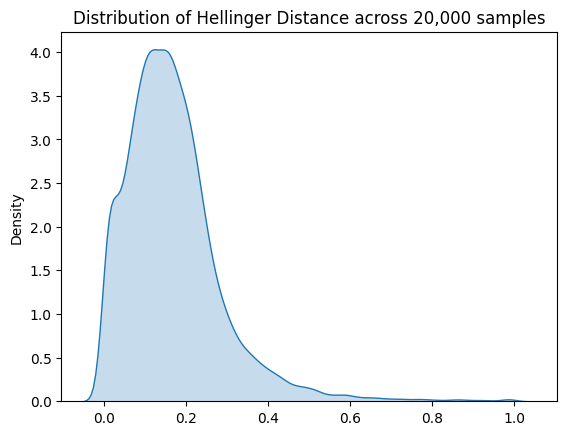

In [ ]:
sns.kdeplot(h.numpy(), fill=True)
plt.title("Distribution of Hellinger Distance across 20,000 samples")
plt.show()

In [ ]:
# Look at some of the very worst ones:
torch.nonzero(h > 0.99)

tensor([[ 4016],
        [ 5411],
        [ 5583],
        [ 8172],
        [13046],
        [14283],
        [17567],
        [17786]])

In [ ]:
q_idx=4016
model_outputs[q_idx], sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)

([('t', 0.7598904967308044),
  ('e', 0.1240471750497818),
  ('l', 0.08614809811115265),
  ('o', 0.011713063344359398),
  ('a', 0.010631212964653969),
  ('n', 0.001669323886744678),
  ('s', 0.0009680230286903679),
  ('u', 0.0008741102647036314),
  ('r', 0.0006283090333454311),
  ('f', 0.0005197310820221901)],
 [('i', 1.0)])

In [ ]:
# Look at sim outputs for all the bad ones.
[
    sim_outputs(q_idx, ffwd_freqs, hand_rolled_coeffs)
    for q_idx in torch.nonzero(h > 0.99).squeeze(dim=-1)
]

[[('i', 1.0)],
 [('S', 1.0)],
 [('l', 1.0)],
 [('P', 1.0)],
 [('S', 1.0)],
 [('A', 1.0)],
 [('S', 1.0)],
 [('Z', 1.0)]]

For each of these, the simulation only has a single prediction. Probably because it didn't get any similar strings to work with. Let's check:

In [ ]:
thresholds = [0.95, 0.94, 0.85, 0.76, 0.81, 0.89]
q_idxs = torch.nonzero(h > 0.99).squeeze(dim=-1)
matching_strings = []
for block_idx in range(n_layer):
    matching_strings.append(
        get_matching_strings(
            filter_across_batches(
                get_batch=lambda batch_idx: torch.load(
                    str(results_folder / f'cosine_sim_ffwd_out_{batch_idx:05d}.pt'),
                    mmap=True,
                )[block_idx, :, q_idxs],
                n_batches=8590,
                filter_fn=lambda batch: batch > thresholds[block_idx],
                n_queries=q_idxs.shape[0],
            ),
            strings10,
        )
    )

In [ ]:
for q_idx in q_idxs:
    print_results(q_idx=(q_idxs == q_idx).nonzero(as_tuple=True)[0], query_string=strings20k[q_idx.item()], matching_strings=matching_strings)
    print()

Query string:  her volub
      her volub |       her volub |       her volub |       her volub |       her volub |       her volub

Query string: o'er!\n\nPRO
    her.\n\nPRO |     her.\n\nPRO |     her.\n\nPRO |     her.\n\nPRO |     her.\n\nPRO |     her.\n\nPRO
    day!\n\nPRO |     day!\n\nPRO |     day!\n\nPRO |     day!\n\nPRO |     day!\n\nPRO |     day!\n\nPRO
   ghts.\n\nPRO |    ghts.\n\nPRO |    ghts.\n\nPRO |    ghts.\n\nPRO |    ghts.\n\nPRO |    ghts.\n\nPRO
   yet.'\n\nPRO |    yet.'\n\nPRO |    yet.'\n\nPRO |    yet.'\n\nPRO |    yet.'\n\nPRO |    yet.'\n\nPRO
    can.\n\nPRO |     can.\n\nPRO |     can.\n\nPRO |     can.\n\nPRO |     can.\n\nPRO |     can.\n\nPRO
   d me?\n\nPRO |    d me?\n\nPRO |    d me?\n\nPRO |    d me?\n\nPRO |    d me?\n\nPRO |    d me?\n\nPRO
    not.\n\nPRO |     not.\n\nPRO |     not.\n\nPRO |     not.\n\nPRO |     not.\n\nPRO |     not.\n\nPRO
   ther?\n\nPRO |    ther?\n\nPRO |    ther?\n\nPRO |    ther?\n\nPRO |    ther?\n\nPRO |    ther?\

In [ ]:
# Were these strings used in training?
for q_idx in torch.nonzero(h > 0.99).squeeze(dim=-1):
    print(f"{q_idx.item()}: {repr(strings20k[q_idx.item()])[1:-1]}, in training? {strings20k[q_idx.item()] in substrings_trained_on}")

4016:  her volub, in training? False
5411: o'er!\n\nPRO, in training? False
5583: uaint Arie, in training? False
8172: tly.\n\nPROS, in training? False
13046:  him.\n\nPRO, in training? False
14283: ople.\n\nSEB, in training? False
17567: ead.\n\nSEBA, in training? False
17786: time.\n\nGON, in training? False


Let's look at how the Hellinger distance stats differ when looking at only strings that were trained on. 

In [ ]:
strings_used_in_training, indices_used_in_training = filter_by_trained_on(
    strings20k,
    substrings_trained_on,
)

In [ ]:
h[indices_used_in_training].mean(), h[indices_used_in_training].min(), h[indices_used_in_training].max()

(tensor(0.1649), tensor(0.0013), tensor(0.9021))

Mean improves a tiny bit, min stays the same, and max gets a lot lower. So this suggests it's throwing out many of the worst strings. Let's look at the distribution.

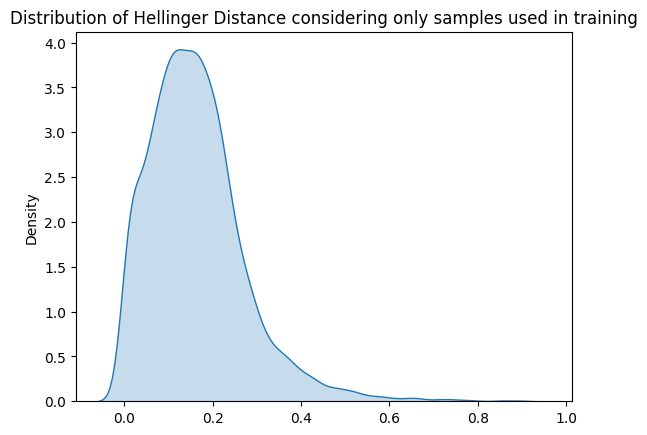

In [ ]:
sns.kdeplot(h[indices_used_in_training].numpy(), fill=True)
plt.title("Distribution of Hellinger Distance considering only samples used in training")
plt.show()

Looks like a smaller tail out at the end. 

In [ ]:
# How many items where there in the original 20k that had worse scores than the
# worst one that was used in training?
(h > h[indices_used_in_training].max()).sum()

tensor(34)

In [ ]:
# Confirm these were all not used in training:
indices = (h > h[indices_used_in_training].max()).nonzero(as_tuple=True)[0]
all([strings20k[i.item()] not in substrings_trained_on for i in indices])


True

Now let's look at *just* the ones not used in training and see what the distribution is.

In [ ]:
indices_not_used_in_training = torch.tensor([i for i in range(len(strings20k)) if i not in indices_used_in_training], dtype=torch.long)
h[indices_not_used_in_training].shape[0], h[indices_not_used_in_training].mean(), h[indices_not_used_in_training].min(), h[indices_not_used_in_training].max()

(1829, tensor(0.2014), tensor(0.0018), tensor(0.9994))

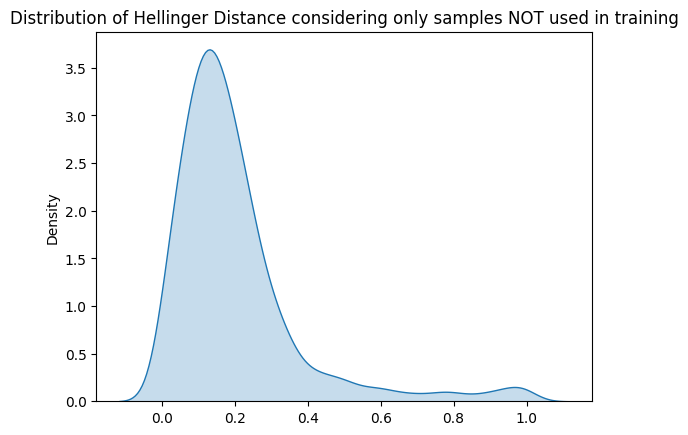

In [ ]:
sns.kdeplot(h[indices_not_used_in_training].numpy(), fill=True)
plt.title("Distribution of Hellinger Distance considering only samples NOT used in training")
plt.show()

So it seems like a lot of the worse performing ones are in this set, but this set also does contain a good number of decently performing ones.

## Selecting Thresholds Revisited
If we select based on the effect of the Hellinger distance, would we choose different thresholds? 

In [ ]:
def hellinger_distance(
    p: torch.Tensor,
    q: torch.Tensor,
):
    return ((p.sqrt() - q.sqrt())**2).sum(dim=-1).sqrt() / math.sqrt(2)

In [ ]:
n_queries_sample = 500
q_idx_start = 0
q_idx_end = n_queries_sample
all_strings = strings10
next_token_map = next_token_map10
model_probs_sample = get_model_probs(strings20k[:n_queries_sample], encoding_helpers)

In [ ]:
def h_stats_for_block(
    block_idx: int,
    threshold: float,
    q_idx_start: int = 0,
    q_idx_end: int = n_queries_sample,
    all_strings: Sequence[str] = strings10,
    next_token_map: Dict[str, int] = next_token_map10,
    model_probs: torch.Tensor = model_probs_sample,
):
    matching_indices = filter_on_prefiltered_results(
        load_prefiltered=lambda q_idx: torch.load(
            prefiltered_filename(q_idx, block_idx)
        ),
        q_idx_start=q_idx_start,
        q_idx_end=q_idx_end,
        filter_fn=lambda values: values > threshold,
    )
    filter_results_strings = get_matching_strings(matching_indices, all_strings)
    filter_result_freqs = torch.stack(
        [
            torch.stack(
                [
                    next_token_map[matching_string]
                    for matching_string in matching_strings
                ]
            ).sum(dim=0)
            for matching_strings in filter_results_strings
        ]
    )
    filter_result_probs = filter_result_freqs / filter_result_freqs.sum(
        dim=-1, keepdim=True
    )
    h_block = hellinger_distance(model_probs, filter_result_probs)
    return h_block.mean(), h_block.min(), h_block.max()

In [ ]:
def h_stats_for_thresholds(
    block_idx: int,
    thresholds: Sequence[float],
    q_idx_start: int = 0,
    q_idx_end: int = n_queries_sample,
    all_strings: Sequence[str] = strings10,
    next_token_map: Dict[str, int] = next_token_map10,
    model_probs: torch.Tensor = model_probs_sample,
):
    stats = [
        h_stats_for_block(
            block_idx=block_idx,
            threshold=threshold,
            q_idx_start=q_idx_start,
            q_idx_end=q_idx_end,
            all_strings=all_strings,
            next_token_map=next_token_map,
            model_probs=model_probs,
        )
        for threshold in thresholds
    ]
    h_means, h_mins, h_maxs = zip(*stats)
    return h_means, h_mins, h_maxs

In [ ]:
def plot_h_stats_vs_thresholds(
    thresholds: Sequence[float],
    data_series: Sequence[Sequence[float]],
    labels: Sequence[str],
    title: str,
):
    for data, label in zip(data_series, labels):
        plt.plot(thresholds, data, label=label)
    plt.legend()
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Hellinger Distance')
    plt.show()

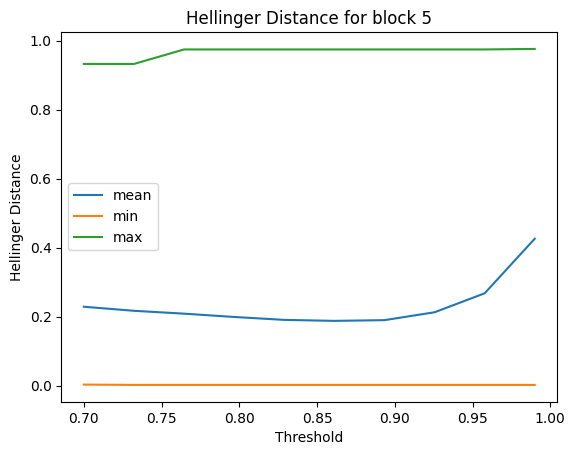

In [ ]:
block_idx = 5
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)


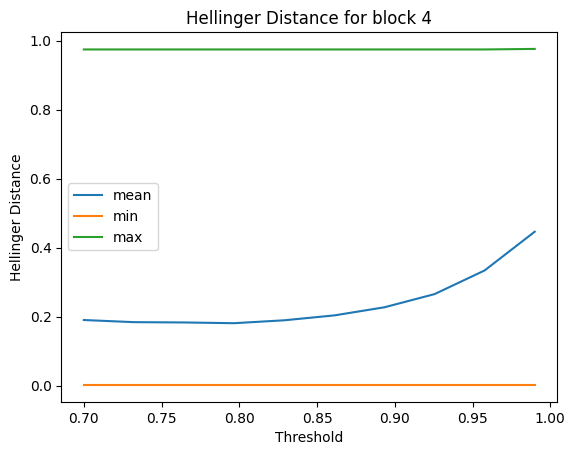

In [ ]:
block_idx = 4
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)

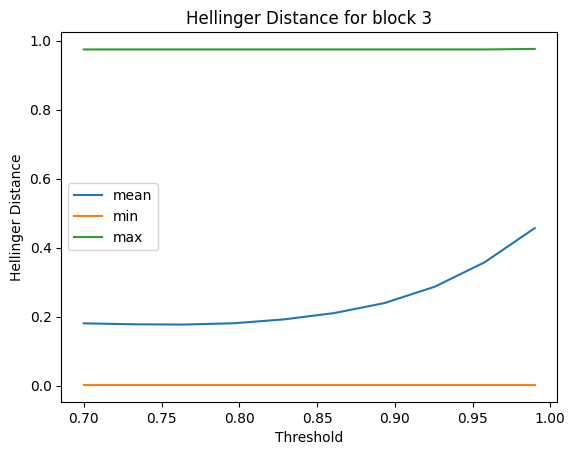

In [ ]:
block_idx = 3
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)

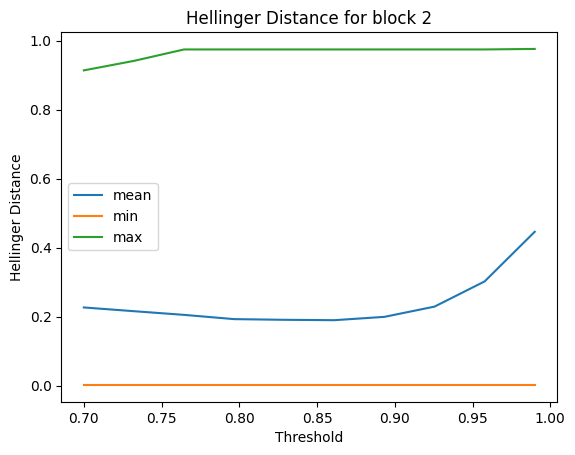

In [ ]:
block_idx = 2
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)

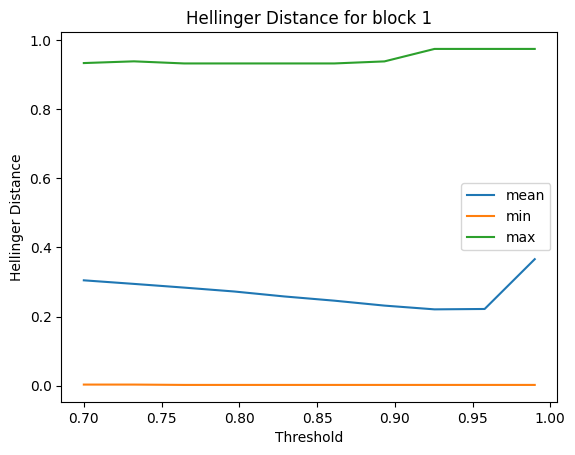

In [ ]:
block_idx = 1
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)

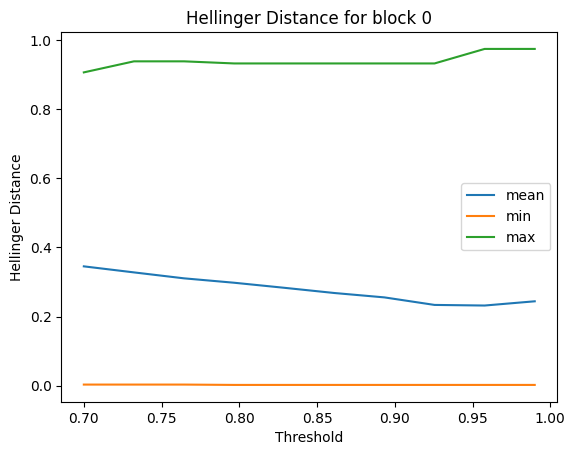

In [ ]:
block_idx = 0
thresholds = np.linspace(0.7, 0.99, 10)
h_means, h_mins, h_maxs = h_stats_for_thresholds(block_idx=block_idx, thresholds=thresholds)
plot_h_stats_vs_thresholds(
    thresholds=thresholds,
    data_series=[h_means, h_mins, h_maxs],
    labels=['mean', 'min', 'max'],
    title=f"Hellinger Distance for block {block_idx}",
)

## Cosine Sims for Length 256 Strings


In [ ]:
strings256 = all_unique_substrings(ts.text, 256)

In [ ]:
torch.manual_seed(1337)
sample_size = 500
indices256 = torch.randperm(len(strings256))[:sample_size]
strings256_sample = [strings256[i.item()] for i in indices256]

In [ ]:
model_outputs_sample256 = get_model_outputs(strings256_sample, encoding_helpers)

In [ ]:
prompts_exp256 = BlockInternalsExperiment(encoding_helpers, accessors, strings256_sample)

In [ ]:
class CosineSimilaritiesForFinalFFWDExperiment:
    def __init__(
        self,
        exp: FinalFFWDExperiment,
        output_folder: Path,
    ):
        self.exp = exp
        self.output_folder = output_folder

        self.n_batches = exp.n_batches

    def ffwd_out_sims_filename(self, batch_idx: int, block_idx: int):
        return self.output_folder / f'ffwds_out_sims_{batch_idx:04d}_{block_idx:02d}.pt'

    def generate_ffwd_out_sims(self, get_queries: Callable[[int], torch.Tensor], disable_progress_bar=False):
        block_idx = n_layer - 1
        for batch_idx in tqdm(range(self.exp.n_batches), disable=disable_progress_bar):
            queries = get_queries(block_idx)
            assert queries.dim() == 2
            n_queries = queries.shape[0]

            ffwd_out_batch = torch.load(str(self.exp._ffwd_output_filename(batch_idx=batch_idx, block_idx=block_idx)), mmap=True)
            batch_size = ffwd_out_batch.shape[0]
            sims = F.cosine_similarity(
                ffwd_out_batch.reshape(batch_size, 1, -1).expand(-1, n_queries, -1),
                queries,
                dim=-1
            )
            torch.save(sims, str(self.ffwd_out_sims_filename(batch_idx=batch_idx, block_idx=block_idx)))




In [ ]:
ffwd_exp256 = FinalFFWDExperiment(
    eh=encoding_helpers,
    accessors=accessors,
    strings=strings256,
    output_dir=environment.data_root / 'block_internals_results/large_files/slen256',
    batch_size=400,
)

In [ ]:
output_folder = ffwd_exp256.output_dir / 'cosine_sims'
output_folder.mkdir(exist_ok=True)

In [ ]:
cos_exp256 = CosineSimilaritiesForFinalFFWDExperiment(ffwd_exp256, output_folder)

In [ ]:
cos_exp256.generate_ffwd_out_sims(get_queries=lambda block_idx: prompts_exp256.ffwd_output(block_idx=block_idx)[:, -1, :])

  0%|          | 0/2788 [00:00<?, ?it/s]

In [ ]:
next_token_map256 = build_next_token_map(ts.text, 256, tokenizer.vocab_size, tokenizer.stoi)

In [ ]:
block_idx = n_layer - 1
ffwd256 = filter_across_batches(
    get_batch=lambda batch_idx: torch.load(str(cos_exp256.ffwd_out_sims_filename(batch_idx=batch_idx, block_idx=block_idx)), mmap=True),
    n_batches=cos_exp256.n_batches,
    filter_fn=lambda batch: batch > 0.91,
    n_queries=sample_size,
)
filter_result_stats(ffwd256)

{'min': 1, 'max': 38780, 'mean': 1561.9, 'std': 4162.8430373964375}

In [ ]:
ffwd256_strings = get_matching_strings(ffwd256, strings256)

In [ ]:
ffwd256_freqs = [
    torch.stack([
        next_token_map256[matching_string]
        for matching_string in matching_strings
    ]).sum(dim=0)
    for matching_strings in ffwd256_strings
]
ffwd256_probs = [
    freqs / freqs.sum()
    for freqs in ffwd256_freqs
]

In [ ]:
topn_matches, topn_matches_any_order = analyze_simulate_results(ffwd256_probs, model_outputs_sample256)
for i in range(10):
    print(f"Top {i+1} matches: {topn_matches[i] / sample_size:.3f}")
    print(f"Top {i+1} matches (any order): {topn_matches_any_order[i] / sample_size:.3f}")

Top 1 matches: 0.802
Top 1 matches (any order): 0.802
Top 2 matches: 0.362
Top 2 matches (any order): 0.412
Top 3 matches: 0.246
Top 3 matches (any order): 0.298
Top 4 matches: 0.200
Top 4 matches (any order): 0.250
Top 5 matches: 0.156
Top 5 matches (any order): 0.154
Top 6 matches: 0.128
Top 6 matches (any order): 0.148
Top 7 matches: 0.070
Top 7 matches (any order): 0.086
Top 8 matches: 0.044
Top 8 matches (any order): 0.068
Top 9 matches: 0.032
Top 9 matches (any order): 0.038
Top 10 matches: 0.030
Top 10 matches (any order): 0.016


In [ ]:
idx = 0
print(f"Query {idx} ({repr(strings256_sample[idx])}): ")
result = ffwd256[idx]
for j in result[:20]:
    print(f"  {repr(strings256[j])}")


Query 0 (" see my shame in him.\nThou art a widow; yet thou art a mother,\nAnd hast the comfort of thy children left thee:\nBut death hath snatch'd my husband from mine arms,\nAnd pluck'd two crutches from my feeble limbs,\nEdward and Clarence. O, what cause have I,\nThin"): 
  " so.\n\nSICINIUS:\nLet them assemble,\nAnd on a safer judgment all revoke\nYour ignorant election; enforce his pride,\nAnd his old hate unto you; besides, forget not\nWith what contempt he wore the humble weed,\nHow in his suit he scorn'd you; but your loves,\nThin"
  "I'ld have beaten him like a dog, but for\ndisturbing the lords within.\n\nAUFIDIUS:\nWhence comest thou? what wouldst thou? thy name?\nWhy speak'st not? speak, man: what's thy name?\n\nCORIOLANUS:\nIf, Tullus,\nNot yet thou knowest me, and, seeing me, dost not\nThin"
  "e not--to save my life, for if\nI had fear'd death, of all the men i' the world\nI would have 'voided thee, but in mere spite,\nTo be full quit of those my banishers,\nStand I bef